In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from scipy.linalg import pascal
from scipy.stats import norm
import warnings
import scipy
warnings.filterwarnings("ignore")

In [2]:
T, N = 1, 2 * 10 ** 2
S_1, S_2, K = 300, 400, 350
r, sigma= 0.1, 0.05
M = N
T_wave = (sigma ** 2) * T / 2
D = (2 * r) / (sigma ** 2)
X_1 = np.log(S_1 / K)
X_2 = np.log(S_2 / K)
X_arr = np.linspace(X_1, X_2, N)

tau = T_wave / N
h = abs(X_1 - X_2) / N
print('tau:', tau)
print('h:', h)
print()
U_shape = (N, N)
print('U_shape:', N * N)
U = np.zeros(U_shape)
print()
print(tau / (pow(h , 2) / 2))

alpha = 1 + tau / pow(h, 2) + tau * (1 + D) / (2 * h)
beta = -tau / (2 * pow(h, 2)) - tau * (1 + D) / (2 * h)
gamma = -tau / (2 * pow(h, 2))

alpha_wave = 1 - tau / pow(h, 2) - tau * (1 + D) / (2 * h)
beta_wave = tau / (2 * pow(h, 2)) + tau * (1 + D) / (2 * h)
gamma_wave = tau / (2 * pow(h, 2))

tau: 6.250000000000001e-06
h: 0.0014384103622589045

U_shape: 40000

6.0414948125848875


In [3]:
print(alpha_wave, beta_wave, gamma_wave)
print(alpha, beta, gamma)

-2.196722918317043 1.686349215170821 1.5103737031462219
4.196722918317042 -1.686349215170821 -1.5103737031462219


In [4]:
# инициализация, граничные условия
D = (2 * r) / (sigma ** 2)

for m in range(len(X_arr)):
    if 1 - np.exp(-X_arr[m]) > 0:
        U[0][m] = 1 - np.exp(-X_arr[m])
    else:
        U[0][m] = 0

for n in range(N):
    U[n, -1] = 1 - np.exp(-D * tau * n - X_arr[-1])

In [5]:
U

array([[0.        , 0.        , 0.        , ..., 0.12246647, 0.12373415,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12543739],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12587456],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20707877],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20747513],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.20787129]])

In [6]:
def get_a_matrix(alpha, beta, gamma, N):
    a = np.zeros((N - 2, N - 2))
    for i in range(N - 2):
            for j in range(N - 2):
                if i == j:
                    a[i][j] = alpha
                if i == j + 1:
                    a[i][j] = gamma
                if i == j - 1:
                    a[i][j] = beta
    return a

In [7]:
a = get_a_matrix(alpha, beta, gamma, N)
a

array([[ 4.19672292, -1.68634922,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.5103737 ,  4.19672292, -1.68634922, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.5103737 ,  4.19672292, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  4.19672292,
        -1.68634922,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.5103737 ,
         4.19672292, -1.68634922],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.5103737 ,  4.19672292]])

In [8]:
def get_U(alpha_wave, beta_wave, gamma_wave, beta, gamma, layer_number, N, a_matrix):
    a = a_matrix
    b = np.zeros(N - 2)     # если размерность сетки N * N
    s = layer_number
    for j in range(len(b)):
        if j == 0:
            b[j] = gamma_wave * U[s][j] + alpha_wave * U[s][j + 1] + beta_wave * U[s][j + 2] - gamma * U[s + 1][j]
        if  j == len(b) - 1:
            b[j] = gamma_wave * U[s][j] + alpha_wave * U[s][j + 1] + beta_wave * U[s][j + 2] - beta * U[s + 1][j + 2]
        if (j > 0) and (j < len(b) - 1):
            b[j] = gamma_wave * U[s][j] + alpha_wave * U[s][j + 1] + beta_wave * U[s][j + 2]

    n = len(b)
    x = np.zeros(len(b)) # обнуление вектора решений

    # Прямой ход
    v = np.zeros(n)
    u = np.zeros(n)
    # для первой 0-й строки
    v[0] = a[0][1] / (-a[0][0]) 
    u[0] = b[0] / a[0][0]
    for i in range(1, n - 1): # заполняем за исключением 1-й и (n-1)-й строк матрицы
        v[i] = a[i][i + 1] / (-a[i][i] - a[i][i - 1] * v[i - 1])
        u[i] = (a[i][i - 1] * u[i - 1] - b[i]) / (-a[i][i] - a[i][i - 1] * v[i - 1])
    # для последней (n-1)-й строки
    v[n - 1] = 0
    u[n - 1] = (a[n - 1][n - 2] * u[n - 2] - b[n - 1]) / (-a[n - 1][n - 1] - a[n - 1][n - 2] * v[n - 2])


    # Обратный ход
    if u[n - 1] > 0:
        x[n - 1] = u[n - 1]
    else:
        x[n - 1] = 0
    for i in range(n - 1, 0, -1):
        if v[i - 1] * x[i] + u[i - 1] > 0:
            x[i - 1] = v[i - 1] * x[i] + u[i - 1]
        else:
            x[i - 1] = 0
    return x

In [9]:
a = get_a_matrix(alpha, beta, gamma, N)
b = get_U(alpha_wave, beta_wave, gamma_wave,beta, gamma, 0, N, a)
for s in range(N - 1):
    U[s + 1][1:-1] = get_U(alpha_wave, beta_wave, gamma_wave,beta, gamma, s, N, a)

In [10]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.113541,0.114822,0.116101,0.117377,0.118652,0.119926,0.121197,0.122466,0.123734,0.125000
1,0.0,1.720917e-36,4.282751e-36,9.116907e-36,1.885290e-35,3.875264e-35,7.955597e-35,1.632778e-34,3.350863e-34,6.876711e-34,...,0.113986,0.115266,0.116544,0.117820,0.119095,0.120367,0.121638,0.122907,0.124173,0.125437
2,0.0,1.346887e-34,3.331512e-34,7.033819e-34,1.441269e-33,2.934463e-33,5.966007e-33,1.212467e-32,2.463691e-32,5.005565e-32,...,0.114431,0.115710,0.116988,0.118263,0.119537,0.120808,0.122078,0.123346,0.124611,0.125875
3,0.0,5.214248e-33,1.281871e-32,2.684104e-32,5.449336e-32,1.098875e-31,2.212298e-31,4.451605e-31,8.955160e-31,1.801092e-30,...,0.114875,0.116154,0.117431,0.118705,0.119978,0.121249,0.122518,0.123785,0.125049,0.126312
4,0.0,1.331405e-31,3.253129e-31,6.755282e-31,1.358774e-30,2.713528e-30,5.409131e-30,1.077564e-29,2.145829e-29,4.271763e-29,...,0.115320,0.116597,0.117873,0.119147,0.120419,0.121689,0.122957,0.124223,0.125487,0.126748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,7.517407e-04,1.430305e-03,2.048072e-03,2.615669e-03,3.142228e-03,3.635590e-03,4.102488e-03,4.548712e-03,4.979234e-03,...,0.195935,0.197091,0.198247,0.199400,0.200552,0.201702,0.202850,0.203997,0.205142,0.206285
196,0.0,7.696341e-04,1.464295e-03,2.096610e-03,2.677426e-03,3.216062e-03,3.720523e-03,4.197686e-03,4.653461e-03,5.092928e-03,...,0.196337,0.197493,0.198647,0.199800,0.200951,0.202101,0.203249,0.204395,0.205539,0.206682
197,0.0,7.877627e-04,1.498730e-03,2.145782e-03,2.739985e-03,3.290849e-03,3.806544e-03,4.294091e-03,4.759524e-03,5.208030e-03,...,0.196738,0.197894,0.199048,0.200200,0.201351,0.202500,0.203647,0.204793,0.205936,0.207079
198,0.0,8.061261e-04,1.533610e-03,2.195587e-03,2.803345e-03,3.366587e-03,3.893651e-03,4.391701e-03,4.866898e-03,5.324537e-03,...,0.197140,0.198295,0.199448,0.200600,0.201750,0.202898,0.204045,0.205190,0.206333,0.207475


In [11]:
V = U * np.linspace(S_1, S_2, N)
V_numerical = pd.DataFrame(V)
ans_numerical = V_numerical.sum(axis=0) / V_numerical.shape[0]

In [12]:
def d_plus(s, sigma, T, t, r, strike): 
    return ((math.log(s / strike)) + (T - t) * (r + (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [13]:
def d_minus(s, sigma, T, t, r, strike):
    return ((math.log(s / strike)) + (T - t) * (r - (sigma ** 2) / 2)) / (sigma * math.sqrt(T - t))

In [14]:
def price_call_option(s, sigma, T, t, r, strike):
    I_plus = norm.cdf(d_plus(s, sigma, T, t, r, strike))
    I_minus = norm.cdf(d_minus(s, sigma, T, t, r, strike))
    ans = s * I_plus - strike * math.exp(-1 * r * (T - t)) * I_minus
    return ans

In [15]:
S_arr = K * np.exp(X_arr)
t_arr = T - (2 / (sigma ** 2)) * np.linspace(0, T_wave, N)

In [16]:
exact = np.zeros((U_shape))
for i in tqdm(range(len(t_arr))):
    for j in range(len(S_arr)):
        exact[i][j] = price_call_option(S_arr[j], sigma, T, t_arr[i], r, K)


100%|██████████| 200/200 [00:09<00:00, 21.17it/s]


In [17]:
V_exact = pd.DataFrame(exact)
ans_exact = V_exact.sum(axis=0) / V_exact.shape[0]
ans_exact

0       0.153985
1       0.164988
2       0.176676
3       0.189083
4       0.202246
         ...    
195    64.623224
196    65.198561
197    65.774730
198    66.351732
199    66.929570
Length: 200, dtype: float64

In [18]:
V_numerical

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,44.902983,45.467120,46.031811,46.597053,47.162846,47.729187,48.296074,48.863507,49.431483,50.000000
1,0.0,5.171400e-34,1.289129e-33,2.748816e-33,5.693766e-33,1.172316e-32,2.410666e-32,4.955768e-32,1.018730e-31,2.094114e-31,...,45.078966,45.643071,46.207728,46.772933,47.338684,47.904972,48.471783,49.039093,49.606852,50.174956
2,0.0,4.047429e-32,1.002802e-31,2.120750e-31,4.352776e-31,8.877121e-31,1.807790e-30,3.680051e-30,7.490115e-30,1.524308e-29,...,45.254853,45.818919,46.383532,46.948682,47.514360,48.080547,48.647216,49.214335,49.781869,50.349825
3,0.0,1.566895e-30,3.858496e-30,8.092776e-30,1.645754e-29,3.324235e-29,6.703596e-29,1.351140e-28,2.722549e-28,5.484732e-28,...,45.430630,45.994645,46.559195,47.124267,47.689844,48.255908,48.822437,49.389411,49.956816,50.524606
4,0.0,4.000905e-29,9.792081e-29,2.036768e-28,4.103633e-28,8.208762e-28,1.639048e-27,3.270597e-27,6.523753e-27,1.300848e-26,...,45.606283,46.170234,46.734707,47.299688,47.865161,48.431111,48.997518,49.564364,50.131626,50.699300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,2.259000e-01,4.305291e-01,6.175090e-01,7.899585e-01,9.505636e-01,1.101638e+00,1.245177e+00,1.382900e+00,1.516289e+00,...,77.487760,78.044272,78.601281,79.158788,79.716789,80.275285,80.834273,81.393753,81.953722,82.514180
196,0.0,2.312770e-01,4.407601e-01,6.321436e-01,8.086095e-01,9.728992e-01,1.127375e+00,1.274072e+00,1.414746e+00,1.550912e+00,...,77.646721,78.203205,78.760187,79.317665,79.875638,80.434105,80.993064,81.552515,82.112455,82.672884
197,0.0,2.367247e-01,4.511252e-01,6.469694e-01,8.275030e-01,9.955232e-01,1.153440e+00,1.303332e+00,1.446991e+00,1.585963e+00,...,77.805603,78.362059,78.919012,79.476462,80.034407,80.592845,81.151776,81.711197,82.271108,82.831508
198,0.0,2.422429e-01,4.616244e-01,6.619860e-01,8.466385e-01,1.018435e+00,1.179835e+00,1.332958e+00,1.479635e+00,1.621442e+00,...,77.964405,78.520833,79.077759,79.635180,80.193096,80.751506,81.310408,81.869800,82.429682,82.990052


In [19]:
(abs(V_exact - V_numerical)).sum().sum() / (N * N)

0.15620739536626765

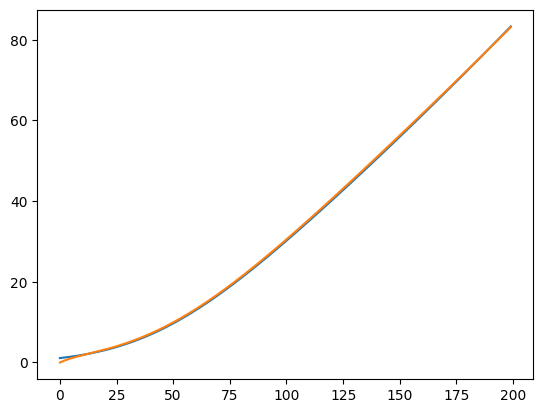

In [21]:
plt.plot(V_exact.iloc[-1])
plt.plot(V_numerical.iloc[-1])
